## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

## Global Variables

In [2]:
interval = '1d' # time interval for data point
history = '10y' # time period for total history
perc_inc = 0.007 # 0.7% increase from interval to interval
symbol = 'IYW'
perc_train = 0.17 # n_estimators from percent of train data set

## Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol
                       , interval = interval
                       , period = history
                       , prepost = True
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700


In [5]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-17,265.429993,266.200012,263.390015,264.000000,264.000000,92800
2020-06-18,263.690002,265.320007,263.000000,265.190002,265.190002,56300
2020-06-19,268.450012,268.450012,262.630005,264.230011,264.230011,116900


## Create Percent Change

In [6]:
stock_df['Percent Change'] = (stock_df.Close - stock_df.Open) / stock_df.Open
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change
Date,,,,,,,
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700,-0.020985
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400,-0.013242
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700,-0.006069


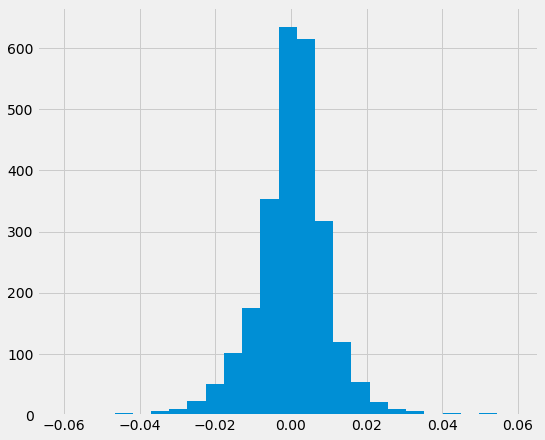

In [7]:
stock_df['Percent Change'].hist(bins=25);

In [8]:
stock_df['Percent Change'].quantile([0.84]) # 1 stdev from avg

0.84    0.007984
Name: Percent Change, dtype: float64

## Assign Direction

In [9]:
stock_df['Direction'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                 , 1
                                 , 0
                                )

In [10]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Date,,,,,,,,
2020-06-15,250.369995,259.369995,250.350006,258.589996,258.589996,124400,0.032831,1
2020-06-16,265.320007,265.660004,259.799988,263.739990,263.739990,127400,-0.005955,0
2020-06-17,265.429993,266.200012,263.390015,264.000000,264.000000,92800,-0.005387,0
2020-06-18,263.690002,265.320007,263.000000,265.190002,265.190002,56300,0.005688,0
2020-06-19,268.450012,268.450012,262.630005,264.230011,264.230011,116900,-0.015720,0


## Shift Direction Column Up

Move decision column up by 1 cell so current hour of data will predict the next hour of data or whichever time frame interval is observed

In [11]:
direction = stock_df.Direction.values
print(f'Length Before: {len(direction)}')
direction = direction[1:len(direction)]
print(f'Length After: {len(direction)}')

Length Before: 2518
Length After: 2517


In [12]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
stock_df_one_off['Direction'] = direction
stock_df_one_off.shape

(2517, 8)

In [13]:
stock_df_one_off.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Date,,,,,,,,
2020-06-12,259.670013,260.630005,251.440002,255.570007,255.127014,150400,-0.015789,1
2020-06-15,250.369995,259.369995,250.350006,258.589996,258.589996,124400,0.032831,0
2020-06-16,265.320007,265.660004,259.799988,263.739990,263.739990,127400,-0.005955,0
2020-06-17,265.429993,266.200012,263.390015,264.000000,264.000000,92800,-0.005387,0
2020-06-18,263.690002,265.320007,263.000000,265.190002,265.190002,56300,0.005688,0


## Balance 1's and 0's

In [14]:
ones_count = stock_df_one_off['Direction'].value_counts()[1]
ones_count

476

In [15]:
stock_df_bal = stock_df_one_off.groupby('Direction').apply(lambda x: x.sample(n=ones_count)).reset_index(drop=True)
stock_df_bal.shape

(952, 8)

In [16]:
stock_df_bal['Direction'].value_counts()

1    476
0    476
Name: Direction, dtype: int64

## Check for NaN's

In [17]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Percent Change    0
Direction         0
dtype: int64

In [18]:
stock_df_bal.dropna(axis=0, inplace=True)

In [19]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Percent Change    0
Direction         0
dtype: int64

## Train Test Split

In [20]:
X = stock_df_bal.drop(columns=['Percent Change', 'Direction'])
y = stock_df_bal['Direction']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.15
                                                    , random_state = 42
                                                   )

## Random Forest Classifier

In [22]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train))
                             , random_state = 42
                             , verbose = 1
                             , n_jobs = -1
                            )

In [23]:
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 137 out of 137 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 137 out of 137 | elapsed:    0.1s finished


## Receiver Operating Characteristic (ROC) Curve

In [24]:
roc_score = roc_auc_score(y_test
                          , y_probs
                         )
roc_score

0.5796083860759493

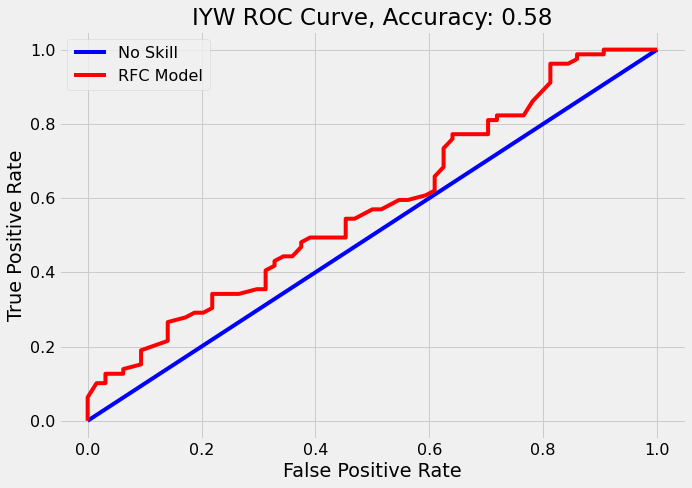

In [25]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10,7))

# No Skill Line Data
base_fpr, base_tpr, _ = roc_curve(y_test
                                  , [1 for _ in range(len(y_test))]
                                 ) 

# Model Data
model_fpr, model_tpr, _ = roc_curve(y_test
                                    , y_probs
                                   )

plt.plot(base_fpr
         , base_tpr
         , 'b'
         , label='No Skill'
        )

plt.plot(model_fpr
         , model_tpr
         , 'r'
         , label='RFC Model'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_score, 3)}')
plt.legend();

## Precision Recall Curve

In [26]:
# Precision Recall Data
rf_prec, rf_recall, _ = precision_recall_curve(y_test
                                             , y_probs
                                            )

auc_score = auc(rf_recall, rf_prec)
auc_score

0.6510303171668826

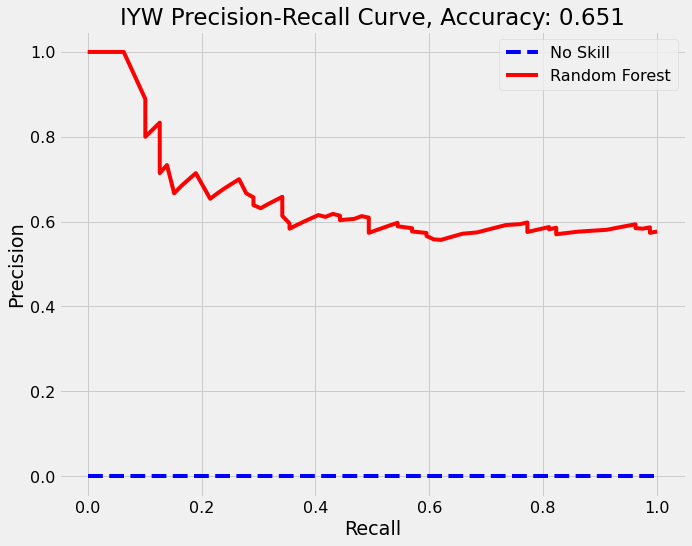

In [27]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 8)



# No Skill Line
plt.plot([0, 0]
         , linestyle = '--'
         , color = 'b'
         , label = 'No Skill'
        )

# PR Line
plt.plot(rf_recall
         , rf_prec
         , color = 'r'
         , label = 'Random Forest'
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc_score, 3)}')
plt.legend();

## Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 137 out of 137 | elapsed:    0.0s finished


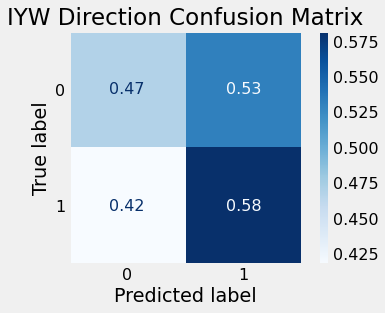

In [28]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                             , X_test
                             , y_test
                             , cmap = plt.cm.Blues
                             , normalize = 'true'
                            )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Direction Confusion Matrix');

## Feature Importances

In [29]:
features_df = pd.DataFrame({'Feature': X_train.columns
                            , 'Importances': rfc.feature_importances_
                           }).sort_values('Importances'
                                          , ascending=False
                                         )
features_df

,Feature,Importances
5,Volume,0.183613
4,Adj Close,0.166656
2,Low,0.166303
0,Open,0.166040
3,Close,0.161292
1,High,0.156096


## Make A Prediction

In [30]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Date,,,,,,,,
2020-06-17,265.429993,266.200012,263.390015,264.000000,264.000000,92800,-0.005387,0
2020-06-18,263.690002,265.320007,263.000000,265.190002,265.190002,56300,0.005688,0
2020-06-19,268.450012,268.450012,262.630005,264.230011,264.230011,116900,-0.015720,0


In [31]:
last = stock_df.drop(columns=['Percent Change', 'Direction']).iloc[-1]
last

Open            268.450012
High            268.450012
Low             262.630005
Close           264.230011
Adj Close       264.230011
Volume       116900.000000
Name: 2020-06-19 00:00:00, dtype: float64

In [32]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} for {round(perc_inc * 100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval for expected {round(perc_inc * 100, 1)}% increase.')

Sell or hold IYW on the 1d interval for expected 0.7% increase.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 137 out of 137 | elapsed:    0.0s finished
